In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import pandas as pd
import ast
import keras
from keras import utils, layers, models, backend
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


class DataPrepare:
    _dir = 'C:/Users/gorsh/Desktop/Moving forward/Research work/' \
           'pythonProjectClass/gorshkov-bachelor-degree-project/'
    _ptb_annot_file = _dir + 'ptb-xl/ptbxl_database.csv'
    _ptb_diagn_file = _dir + 'ptb-xl/scp_statements.csv'
    _lob_path = _dir + 'Lobachevsky data/'
    _ptb_path = _dir + 'ptb-xl/'
    _lob_file_names = [str(i) for i in range(1, 201)]

    
    def __init__(self):
        """Тут пока ничего не делаем"""
# , model
#         self._lst_more_sigma_ptb = model._lst_more_sigma_ptb
#         self._X_ptb_lead_sigm = model._X_ptb_lead_sigm
        
#         self._X_ptb_lead = model._X_ptb_lead
#         self._Y_ptb_annot = model._Y_ptb_annot
#         self._X_ptb = model._X_ptb
#         self._Y_ptb_oh = model._Y_ptb_oh
        
#         self._Y_lob_annot = model._Y_lob_annot
#         self._X_lob_lead = model._X_lob_lead
#         self._X_val = model._X_val        

#         self._Y_val_oh = model._Y_val_oh
        
#         self._X_train = model._X_train
#         self._X_test = model._X_test
#         self._Y_train = model._Y_train
#         self._Y_test = model._Y_test
        
#         self._oh_enc = model._oh_enc
#         self._le_enc = model._le_enc
#     # add_prepr and CWT 
#         self._X_val_cut = model._X_val_cut
#         self._X_val_cwt = model._X_val_cwt
#         self._X_train_cut = model._X_train_cut
#         self._X_train_cwt = model._X_train_cwt
#         self._X_test_cut = model._X_test_cut
#         self._X_test_cwt = model._X_test_cwt


    def _load_annot_ptb(self):
        """Загружаем аннотации к отведениям"""

        self._Y_ptb_annot = pd.read_csv(self._ptb_annot_file, index_col='ecg_id')
        self._Y_ptb_annot.scp_codes = self._Y_ptb_annot.scp_codes.apply(lambda x: ast.literal_eval(x))
        self._all_diagnosis = pd.read_csv(self._ptb_diagn_file, index_col=0)
        self._all_diagnosis = self._all_diagnosis[self._all_diagnosis.diagnostic == 1]
        
        print('First size of ptb labels: ', self._Y_ptb_annot.shape)

    def _clean_ptb(self):
        """Оставляем интересующие диагнозы"""

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in self._all_diagnosis.index:
                    tmp.append(self._all_diagnosis.loc[key].diagnostic_class)
            return list(set(tmp))

#         drop_index = ['2AVB']
        drop_index = ['ILMI', 'IPLMI', 'IPMI', 'INJIN', 'INJIL', 'ALMI', 'ASMI', 
              'INJAS', 'INJLA', 'INJAL', 'LMI', 'PMI', 'RAO/RAE', 'RVH', 
              'SEHYP', 'IVCD', 'LAFB', 'LPFB', 'WPW', '2AVB', 'ISCAL', 
              'ISCAS', 'ISCIL', 'ISC_', 'NST_', 'NDT', 'DIG', 'LNGQT',
              'ANEUR', 'ISCLA', 'ISCAN', 'ISCIN', 'EL', 'NORM']
    
        
#         drop_subclass = ['LAFB/LPFB', 'PMI', 'SE', 'WPW', 'SEHYP', 'IVCD', 'RVH', 'RAO/RAE', 'LMI', 'ILBBB']
        drop_subclass = []
#         drop_class = ['STTC']
        drop_class = []


        self._all_diagnosis.drop(index=self._all_diagnosis.loc[self._all_diagnosis.index.isin(drop_index)].index, inplace=True)
#         self._all_diagnosis.drop(index=self._all_diagnosis.loc[self._all_diagnosis.diagnostic_class.isin(drop_class)].index, inplace=True)
#         self._all_diagnosis.drop(index=self._all_diagnosis.loc[self._all_diagnosis.diagnostic_subclass.isin(drop_subclass)].index, inplace=True)

        self._Y_ptb_annot['diagnostic_superclass'] = self._Y_ptb_annot.scp_codes.apply(aggregate_diagnostic)

    # Формируем лист для выбрасывания
        lst_drop = []
        self._Y_ptb_annot.reset_index(inplace=True)
        for ind in self._Y_ptb_annot.index:
            if len(self._Y_ptb_annot.diagnostic_superclass.values[ind]) != 1:
                lst_drop.append(ind)
        self._Y_ptb_annot.drop(index=lst_drop, inplace=True)
    # Переиндексируем
        self._Y_ptb_annot = self._Y_ptb_annot.sample(frac=1, random_state=56)
        self._Y_ptb_annot.reset_index(inplace=True)
        
    # Оставлям вместо листа один его элемент
        self._Y_ptb_annot['diagnostic_class'] = self._Y_ptb_annot.diagnostic_superclass.apply(lambda x: x[0])
        print(self._Y_ptb_annot.diagnostic_class.value_counts())

    def _load_lead_ptb(self):
        """Загружаем отведения"""

        def load_raw_data(df, sampling_rate, path):
            if sampling_rate == 100:
                data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data

        self._X_ptb_lead = load_raw_data(self._Y_ptb_annot, 500, self._ptb_path)

    def _load_annot_lob(self):
        """Загружаем аннотации к отведениям"""

        self._lob_list_diagn = []
        for name in self._lob_file_names:
            self._lob_list_diagn.append(wfdb.rdrecord(self._lob_path + name).comments[3:])

    def _clean_lob(self):
        """Осталяем интересующие диагнозы"""

        # region check_functions
        def check_norm(lst):
            if not lst:
                return True
            return False

        def check_ishem(lst):
            for l in lst:
                if not l in MI:
                    return False
            return True

        def check_cond(lst):
            for l in lst:
                if not l in CD:
                    return False
            return True

        def check_hyp(lst):
            for l in lst:
                if not l in HYP:
                    return False
            return True
        
        def check_sttc(lst):
            for l in lst:
                if not l in STTC:
                    return False
            return True
        #endregion check_functions
        MI = ['STEMI: inferior wall.', 'STEMI: anterior wall.']
        HYP = ['Left atrial overload.', 'Left atrial hypertrophy.', 'Left ventricular hypertrophy.']
        CD = ['Complete left bundle branch block.', 'Complete right bundle branch block.',
              'Incomplete left bundle branch block.', 'Incomplete right bundle branch block.',
              'I degree AV block','III degree AV-block.']
        STTC = ['Ischemia: lateral wall.', 'Ischemia: anterior wall.','Ischemia: inferior wall.']
   
#         ischemia = ['STEMI: anterior wall.', 'STEMI: inferior wall.']
#         , 'STEMI: lateral wall.'
#         condition = ['I degree AV block.', 'III degree AV-block.', 'Incomplete right bundle branch block.',
#                      'Complete right bundle branch block.','Complete left bundle branch block.']
    #, 'Non-specific intravintricular conduction delay.','Incomplete left bundle branch block.', 
#         hypertrophy = ['Left atrial hypertrophy.', 'Left atrial overload.', 'Left ventricular hypertrophy.']
# 'Right atrial hypertrophy.', 'Right atrial overload.', 'Right ventricular hypertrophy.'
        
        new_list_diagn = [[] for i in range(200)]
        for i in range(len(self._lob_list_diagn)):
            for d in self._lob_list_diagn[i]:
                if d in MI or d in HYP or d in CD:
                    new_list_diagn[i].append(d)

        self._Y_lob_annot = pd.DataFrame({'name': [], 'diagn': []})

        for i in range(len(new_list_diagn)):
#             if check_norm(new_list_diagn[i]):
#                 self._Y_lob_annot = self._Y_lob_annot.append({'name': str(i + 1), 'diagn': 'NORM'}, ignore_index=True)
            if check_cond(new_list_diagn[i]):
                self._Y_lob_annot = self._Y_lob_annot.append({'name': str(i + 1), 'diagn': 'CD'}, ignore_index=True)
            elif check_hyp(new_list_diagn[i]):
                self._Y_lob_annot = self._Y_lob_annot.append({'name': str(i + 1), 'diagn': 'HYP'}, ignore_index=True)
            elif check_ishem(new_list_diagn[i]):
                self._Y_lob_annot = self._Y_lob_annot.append({'name': str(i + 1), 'diagn': 'MI'}, ignore_index=True)
#             elif check_sttc(new_list_diagn[i]):
#                 self._Y_lob_annot = self._Y_lob_annot.append({'name': str(i + 1), 'diagn': 'STTC'}, ignore_index=True)


    def _load_lead_lob(self):
        """Загружаем отведения"""

        self._X_lob_lead = np.array([wfdb.rdsamp(self._lob_path + f)[0] for f in self._Y_lob_annot.name])

##########################################################
##########################################################
##########################################################
        
    def _ptb_prepr(self):
        """Выполняем фильтрацию элементов, в рядах которых змечено отклонение большее сигмы этого ряда,
        выполняем дискретное вейвлет пребразование, масштабирование и кодирование меток
        """
        
    #Составляем список для фильтрации
        def check_out(mas, std):
            for i in range(mas.shape[0]):
                for j in range(mas.shape[1]):
                    if -1 * std[j] > mas[i, j] or 1 * std[j] < mas[i, j]:
                        return True
            return False
        
        self._sub_std_ptb = self._X_ptb_lead.std(axis=(1))
        self._sub_std_max_ptb = self._sub_std_ptb.max(axis=(0))
        self._lst_more_sigma_ptb = []
        for j in range(self._X_ptb_lead.shape[0]):
            if check_out(self._X_ptb_lead[j], self._sub_std_max_ptb):
                self._lst_more_sigma_ptb.append(j)
    #Фильтруем
        self._X_ptb_lead_sigm = np.delete(self._X_ptb_lead, self._lst_more_sigma_ptb, axis=0)
        self._Y_ptb_annot.drop(index=self._lst_more_sigma_ptb, inplace=True)
        
        self._Y_ptb_annot.drop(columns=['index'], inplace=True)
        self._Y_ptb_annot.reset_index(inplace=True)
        
        print('Second size of ptb labels: ', self._Y_ptb_annot.shape)
        print(self._Y_ptb_annot.diagnostic_class.value_counts())
        
#     #Уменьшаем дисбаланс
#         np.random.seed(134)
#         ind_norm = self._Y_ptb_annot.loc[self._Y_ptb_annot.diagnostic_class == "NORM"].index
#         ind_mi = self._Y_ptb_annot.loc[self._Y_ptb_annot.diagnostic_class == "MI"].index
# #         ind_hyp = self._Y_ptb_annot.loc[self._Y_ptb_annot.diagnostic_class == "HYP"].index
        
#         p_norm = np.random.permutation(len(ind_norm))
#         ind_norm = ind_norm[p_norm]
#         ind_norm = ind_norm[:7400]
#         p_mi = np.random.permutation(len(ind_mi))
#         ind_mi = ind_mi[p_mi]
#         ind_mi = ind_mi[:2300]
# #         p_hyp = np.random.permutation(len(ind_hyp))
# #         ind_hyp = ind_hyp[p_hyp]
# #         ind_hyp = ind_hyp[:146]
        
#         ind = np.concatenate([ind_norm, ind_mi], axis=0)
        
#         self._X_ptb_lead_sigm = np.delete(self._X_ptb_lead_sigm, ind, axis=0)
#         self._Y_ptb_annot.drop(index=ind, inplace=True)
        
#         self._Y_ptb_annot.drop(columns=['index'], inplace=True)
#         self._Y_ptb_annot.reset_index(inplace=True)
        self._Y_ptb = self._Y_ptb_annot.diagnostic_class.to_numpy()
        
#         print('Third size of ptb labels: ', self._Y_ptb_annot.shape)
#         print(self._Y_ptb_annot.diagnostic_class.value_counts())
        
    #Готовим тензор под результат DWT
        self._X_ptb = np.zeros((self._X_ptb_lead_sigm.shape[0], 12, 174))
    
    #Кодируем метки
        self._oh_enc = OneHotEncoder(sparse=False)
        self._le_enc = LabelEncoder()
        
        self._Y_ptb_le = self._le_enc.fit_transform(self._Y_ptb)
        self._Y_ptb_oh = self._oh_enc.fit_transform(self._Y_ptb_le.reshape(-1,1))
    #Выполняем DWT
        for m in range(self._X_ptb_lead_sigm.shape[0]):
            for v in range(self._X_ptb_lead_sigm.shape[2]):
                self._X_ptb[m] = pywt.wavedec(self._X_ptb_lead_sigm[m, :, v], 'sym10', level=5)[0].T

    #Находим минимумы и максимумы
        self._maxs_ptb = self._X_ptb_lead_sigm.max(axis=(1))
        self._mins_ptb = self._X_ptb_lead_sigm.min(axis=(1))
        
#         self._mins_lead = self._mins_ptb.min(axis=0)
#         self._maxs_lead = self._maxs_ptb.max(axis=0)
        
    #Масштабируем (по максимому в отведении)
#         for i in range(self._X_ptb.shape[0]): #l
#             for j in range(self._X_ptb.shape[1]): #12
#                 for k in range(self._X_ptb.shape[2]): #174
#                     self._X_ptb[i, j, k] = (self._X_ptb[i, j, k] - self._mins_lead[j]) / \
#                                             (self._maxs_lead[j] - self._mins_lead[j])

    
        for i in range(self._X_ptb.shape[0]): #l
            for j in range(self._X_ptb.shape[1]): #12
                for k in range(self._X_ptb.shape[2]): #174
                    self._X_ptb[i, j, k] = (self._X_ptb[i, j, k] - self._mins_ptb[i, j]) / \
                                            (self._maxs_ptb[i, j] - self._mins_ptb[i, j])
                    
#         self._mean_tr = self._X_ptb.mean(axis=(0, 1))
#         self._std_tr = self._X_ptb.std(axis=(0, 1))
#         self._X_ptb = (self._X_ptb - self._mean_tr) / self._std_tr
    #Разделяем на обучение и тест
        self._X_train, self._X_test, self._Y_train, self._Y_test = train_test_split(
            self._X_ptb,
            self._Y_ptb_oh,
            test_size=0.3,
            random_state=45342
        )

    def _lob_prepr(self):
        """Выполняем фильтрацию элементов, в рядах которых змаечено отклонение большее сигмы этого ряда,
        выполняем дискретное вейвлет пребразование, масштабирование и кодирование меток
        """
    
    #Готовим тензор под результат DWT
        self._X_val = np.zeros((self._X_lob_lead.shape[0], 12, 174))
    #Кодируем и бинаризуем метки
        self._Y_val = self._Y_lob_annot.diagn.to_numpy()
        self._Y_val_le = self._le_enc.transform(self._Y_val)
        self._Y_val_oh = self._oh_enc.transform(self._Y_val_le.reshape(-1,1))
    #Выполняем DWT
        for m in range(self._X_lob_lead.shape[0]):
            for v in range(self._X_lob_lead.shape[2]):
                self._X_val[m] = pywt.wavedec(self._X_lob_lead[m, :, v], 'sym10', level=5)[0].T

##############################################

    #Находим минимумы и максимумы
        self._maxs_lob = self._X_lob_lead.max(axis=(1))
        self._mins_lob = self._X_lob_lead.min(axis=(1))
    
    #         koef = 1000
    #         self._X_val = (self._X_val - self._mean_tr * koef) / self._std_tr / koef
    #Масштабируем
        for i in range(self._X_val.shape[0]): #l
            for j in range(self._X_val.shape[1]): #12 
                for k in range(self._X_val.shape[2]): #174
                    self._X_val[i, j, k] = (self._X_val[i, j, k] - self._mins_lob[i, j]) / \
                                           (self._maxs_lob[i, j] - self._mins_lob[i, j])
    
    
    def make_CWT(self, df, w, size, leng):
        widths = np.arange(1, w + 1)
        CWT = np.zeros((size, w, leng))
        for ind in range(df.shape[0]):
            CWT[ind] = pywt.cwt(df[ind], widths, 'mexh')[0]
        return CWT
    
    
    def _ptb_CWT(self):
        self._X_train_cwt = self.make_CWT(self._X_train_vect, 20, self._X_train_vect.shape[0], self._X_train_vect.shape[1])
        self._X_test_cwt = self.make_CWT(self._X_test_vect, 20, self._X_test_vect.shape[0], self._X_test_vect.shape[1])

        
    def _val_CWT(self):
        self._X_val_cwt = self.make_CWT(self._X_val_vectors, 20, self._X_val_vectors.shape[0], self._X_val_vectors.shape[1])
        
        
    def _add_prepr(self):
        padding = 20
        self._X_val_cut = np.zeros((self._X_val.shape[0], self._X_val.shape[1], 174 - 2 * padding))
        for i in range(self._X_val.shape[0]):
            for j in range(self._X_val.shape[1]):
                self._X_val_cut[i, j] = self._X_val[i, j, padding : -padding]
         
        self._X_test_cut = np.zeros((self._X_test.shape[0], self._X_test.shape[1], 174 - 2 * padding))
        for i in range(self._X_test.shape[0]):
            for j in range(self._X_test.shape[1]):       
                self._X_test_cut[i, j] = self._X_test[i, j, padding : -padding]
        
        self._X_train_cut = np.zeros((self._X_train.shape[0], self._X_train.shape[1], 174 - 2 * padding))
        for i in range(self._X_train.shape[0]):
            for j in range(self._X_train.shape[1]):
                self._X_train_cut[i, j] = self._X_train[i, j, padding : -padding]
        
        self._X_val_vectors = self._X_val_cut.reshape(self._X_val_cut.shape[0], -1)
        self._X_train_vect = self._X_train_cut.reshape(self._X_train_cut.shape[0], -1)
        self._X_test_vect = self._X_test_cut.reshape(self._X_test_cut.shape[0], -1)
        

    def _learn_model_2(self):
        """Модель для варианта с CWT"""
        backend.clear_session()
        self._model = models.Sequential()
        self._model.add(layers.Conv2D(
            filters=4, 
            kernel_size=5, 
            strides=1, 
            padding='same', 
            input_shape=(self._X_train_cwt.shape[1], self._X_train_cwt.shape[2], 1)
        ))
        self._model.add(layers.MaxPool2D())
        self._model.add(layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same'))
        self._model.add(layers.MaxPool2D())
        self._model.add(layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same'))
        self._model.add(layers.MaxPool2D())
        self._model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same'))
        self._model.add(layers.MaxPool2D())
#         self._model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same'))
#         self._model.add(layers.MaxPool2D())
#         self._model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same'))
#         self._model.add(layers.MaxPool2D())
        self._model.add(layers.Flatten())
        self._model.add(layers.Dense(128, activation='relu'))
        self._model.add(layers.Dropout(0.5))
        self._model.add(layers.Dense(64, activation='relu'))
        self._model.add(layers.Dropout(0.3))
#         self._model.add(layers.Dense(64, activation='relu'))
#         self._model.add(layers.Dropout(0.1))
        self._model.add(layers.Dense(3, activation='softmax'))

        print(self._model.summary())
        self._model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        self._history = self._model.fit(
            self._X_train_cwt[:, :, :, np.newaxis],
            self._Y_train,
            batch_size=32,
            epochs=10,
            validation_data=(self._X_test_cwt[:, :, :, np.newaxis], self._Y_test))
        
        
##############################################################
#####################  Обучение модели  ######################
##############################################################
    
    def _learn_model(self):
        """Модель для варианта без CWT"""
        backend.clear_session()
        self._model = models.Sequential()
        self._model.add(layers.Reshape(target_shape=(-1, 1), input_shape=(12, self._X_train.shape[2], 1)))
        self._model.add(layers.Conv1D(filters=2, kernel_size=5, strides=1, padding='valid'))
        self._model.add(layers.MaxPool1D())
        self._model.add(layers.Conv1D(filters=4, kernel_size=5, strides=1, padding='valid'))
        self._model.add(layers.MaxPool1D())
        self._model.add(layers.Conv1D(filters=8, kernel_size=5, strides=1, padding='valid'))
        self._model.add(layers.MaxPool1D())
        self._model.add(layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='valid'))
        self._model.add(layers.MaxPool1D())
        self._model.add(layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same'))
#         self._model.add(layers.MaxPool1D())
#         self._model.add(layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same'))
        self._model.add(layers.MaxPool1D())
        self._model.add(layers.Flatten())
        self._model.add(layers.Dense(64, activation='relu'))
        self._model.add(layers.Dense(4, activation='softmax'))

        print(self._model.summary())
        self._model.compile(
            loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )
        self._history = self._model.fit(
            self._X_train[:, :, :, np.newaxis],
            self._Y_train,
            batch_size=32,
            epochs=10,
            validation_data=(self._X_test[:, :, :, np.newaxis], self._Y_test))

        
    def fit(self):
        """Последовательно запускаем все этапы ввода и предобработки данных и обучаем модель"""
        self._load_annot_ptb()
        self._clean_ptb()
        self._load_lead_ptb()
        self._ptb_prepr()
        self._load_annot_lob()
        self._clean_lob()
        self._load_lead_lob()
        self._lob_prepr()
        self._add_prepr()
        self._ptb_CWT()
        self._val_CWT()
        self._learn_model_2()

    def predict(self):
        """Проверяем качество на валидации и выводим графики"""
        print(self._le_enc.classes_)
        plt.style.use(['dark_background'])
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.plot(self._history.history['accuracy'])
        plt.plot(self._history.history['val_accuracy'])
        plt.legend('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
        
        plt.style.use(['dark_background'])
        fig, ax = plt.subplots(figsize=(10, 5))
        plt.plot(self._history.history['loss'])
        plt.plot(self._history.history['val_loss'])
        plt.legend('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        CNN_estimator_y_pred_val = self._model.predict_classes(self._X_val_cwt[:, :, :, np.newaxis])
        CNN_estimator_y_pred_test = self._model.predict_classes(self._X_test_cwt[:, :, :, np.newaxis])
#         print('accuracy test:\t', accuracy_score(self._Y_test, CNN_estimator_y_pred_test))
#         print('accuracy val:\t', accuracy_score(self._Y_val, CNN_estimator_y_pred_val))
        print('Validate')
        print(classification_report(self._oh_enc.inverse_transform(self._Y_val_oh).flatten(), CNN_estimator_y_pred_val))
#                                     _Y_val_le, CNN_estimator_y_pred_val))
        print('Test')
        print(classification_report(self._oh_enc.inverse_transform(self._Y_test).flatten(), CNN_estimator_y_pred_test))


### Запуск

In [10]:
model._Y_ptb_annot.diagnostic_class.value_counts()

MI     1554
CD     1106
HYP     266
Name: diagnostic_class, dtype: int64

In [85]:
model._Y_lob_annot.diagn.value_counts()

HYP    95
CD     66
MI      1
Name: diagn, dtype: int64

In [134]:
model_2 = model_2

In [8]:
model = DataPrepare()
model.fit()

First size of ptb labels:  (21837, 27)
MI     2186
CD     2140
HYP    1779
Name: diagnostic_class, dtype: int64
Second size of ptb labels:  (2926, 31)
MI     1554
CD     1106
HYP     266
Name: diagnostic_class, dtype: int64
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 1608, 4)       104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 804, 4)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 804, 16)       1616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 402, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 402, 32)        12832     
______________________________

['CD' 'HYP' 'MI']


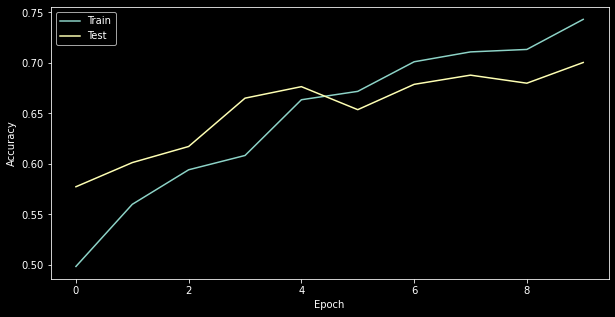

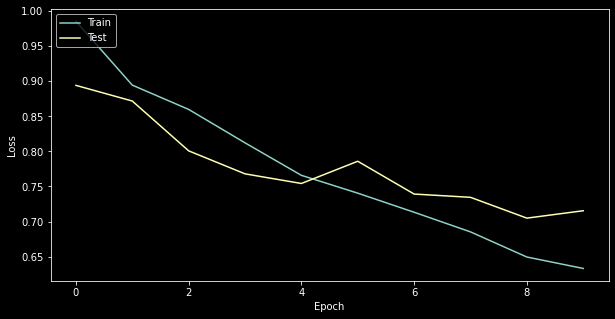

C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Validate
              precision    recall  f1-score   support

           0       0.53      0.80      0.64        66
           1       1.00      0.06      0.12        95
           2       0.02      1.00      0.04         1

    accuracy                           0.37       162
   macro avg       0.52      0.62      0.26       162
weighted avg       0.80      0.37      0.33       162

Test
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       326
           1       0.51      0.26      0.35        84
           2       0.74      0.76      0.75       468

    accuracy                           0.70       878
   macro avg       0.64      0.58      0.60       878
weighted avg       0.69      0.70      0.69       878



In [9]:
model.predict()
# model._le_enc.classes_

In [119]:
CNN_estimator_y_pred_val = model._model.predict_classes(model._X_val_cwt)
CNN_estimator_y_pred_test = model._model.predict_classes(model._X_test_cwt)
print('accuracy test:\t', accuracy_score(model._Y_test, CNN_estimator_y_pred_test))
print('accuracy val:\t', accuracy_score(model._Y_val, CNN_estimator_y_pred_val))
print('Validate')
print(classification_report(model._Y_val_le, CNN_estimator_y_pred_val))
print('Test')
print(classification_report(model._oh_enc.inverse_transform(model._Y_test).flatten(), CNN_estimator_y_pred_test))

ValueError: in user code:

    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 20, 1608)


In [128]:
model._X_val_cwt.shape[2]/12
# model._X_train_cwt.shape[2]/12
# model._X_test_cwt.shape[2]/12

134.0

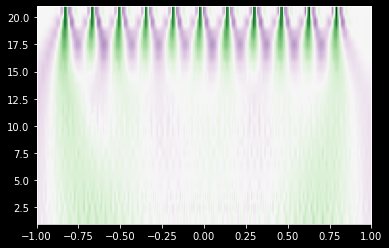

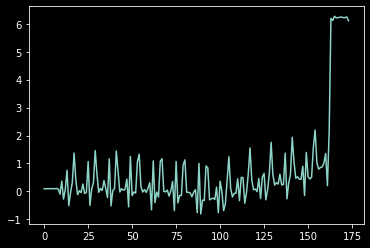

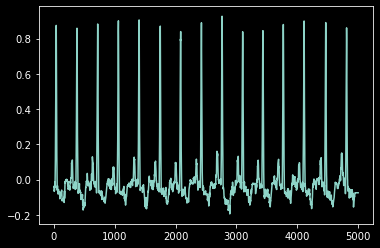

In [82]:
el = 2
plt.imshow(cwt_matr_val[el], extent=[-1, 1, 1, 21], cmap='PRGn', aspect='auto', \
    vmax=abs(cwt_matr_val[el]).max(), vmin=-abs(cwt_matr_val[el]).max())
plt.show()
plt.plot(model._X_ptb[el, 0])
plt.show()
plt.plot(model._X_ptb_lead[el, :, 0])

### Анализ

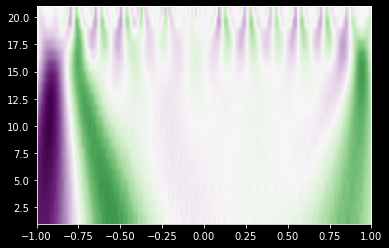

In [75]:
cwt_matr_val = make_CWT(model._X_val, 20, model._X_val.shape[0], model._X_val.shape[2])
el = 5
plt.imshow(cwt_matr_val[el], extent=[-1, 1, 1, 21], cmap='PRGn', aspect='auto', \
    vmax=abs(cwt_matr_val[el]).max(), vmin=-abs(cwt_matr_val[el]).max())

In [9]:
sub_max_ptb = model._X_ptb_lead_sigm.max(axis=(1))
sub_min_ptb = model._X_ptb_lead_sigm.min(axis=(1))
print(np.median(sub_max_ptb, axis=0))
print(np.median(sub_min_ptb, axis=0))
print()
print(np.max(sub_max_ptb, axis=0))
print(np.min(sub_min_ptb, axis=0))

[0.801 0.77  0.364 0.215 0.553 0.482 0.267 0.605 0.835 1.314 1.352 1.097]
[-0.231 -0.281 -0.442 -0.756 -0.229 -0.281 -0.915 -1.272 -1.058 -0.689
 -0.395 -0.263]

[3.114 2.768 3.452 2.276 3.189 2.935 2.49  2.555 2.95  2.523 9.17  4.421]
[ -3.18   -2.345  -3.605  -2.098  -3.198  -2.65   -2.494  -2.558  -2.978
  -2.52  -10.856  -4.642]


In [27]:
sub_max_lob = model._X_lob_lead.max(axis=(1))
sub_min_lob = model._X_lob_lead.min(axis=(1))
print(np.median(sub_max_lob, axis=0))
print(np.median(sub_min_lob, axis=0))
print()
print(np.max(sub_max_lob, axis=0))
print(np.min(sub_min_lob, axis=0))

[ 763.99892317 1123.50523779  694.99970583  240.50269468  471.99735598
  862.4993501   470.98939715  720.99038724  963.48962989 1564.50414675
 1597.50280792 1380.99585985]
[ -270.99678731  -322.49823908  -421.0037253   -890.50559524
  -340.50107727  -325.50056953 -1148.49965307 -1435.00999681
 -1205.00442102  -803.51057981  -496.00860707  -341.0012886 ]

[2228.98460453 2891.01394057 6235.01632392 1529.99524889 1840.01834769
 4449.98857986 3159.9733619  3120.02488352 2941.01413115 9412.00239207
 4544.9853093  8032.0273435 ]
[-4500.02884528 -2319.00778771 -2418.99266809 -1811.00655357
 -5219.96799747 -2369.00972634 -2345.00274574 -4255.03140559
 -3690.00433395 -3579.9819928  -2039.0098564  -1482.98360078]


In [4]:
sub_std_ptb = model._X_ptb_lead.std(axis=(1))
sub_std_lob = model._X_lob_lead.std(axis=(1))
print(sub_std_ptb.max(axis=0))
print(sub_std_lob.max(axis=0))

[12.12399307  3.40747209  5.87009079  3.40915053  5.85167921  2.954686
  2.49805136  2.55982014  2.9875634   2.52324529 11.62099849  4.67850324]
[ 470.24337698  551.02105957  629.62894998  486.91010005  436.45126964
  521.5668224   459.20726408  919.90015169  793.88457773  868.57255835
  652.14393956 1754.92871994]


In [44]:
index = -1
for i in range(15893):
    if 30.699 == model._X_ptb_lead[i, :, 8].max():
        index = i
        

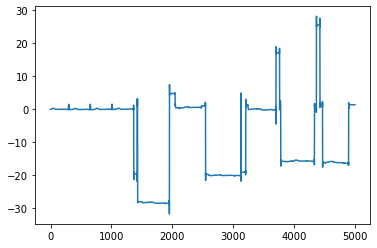

In [37]:
plt.plot(model._X_ptb_lead[lst_ind[9], :, 10])


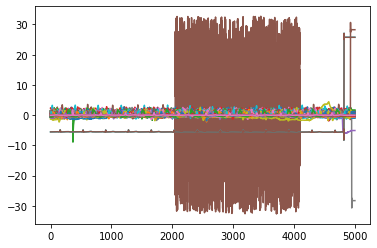

In [74]:
for i in range(len(lst_ind_3)):
#     print(i, model._Y_ptb_annot.loc[lst_ind_3[i]].diagnostic_class)
    plt.plot(model._X_ptb_lead[lst_ind_3[i], :, 0])

In [55]:
def check_out(mas, std):
    for i in range(mas.shape[0]):
        for j in range(mas.shape[1]):
            if -1 * std[j] > mas[i, j] or 1 * std[j] < mas[i, j]:
                return True
    return False

sub_std_max_ptb = sub_std_ptb.max(axis=0)
count_3 = 0
lst_ind_3 = []
for j in range(model._X_ptb_lead.shape[0]):
    if check_out(model._X_ptb_lead[j], sub_std_max_ptb):
        count_3 += 1
        lst_ind_3.append(j)
        


In [97]:
model._Y_ptb_annot.diagnostic_class.value_counts()

NORM    3761
MI      3231
HYP     1235
CD      1089
Name: diagnostic_class, dtype: int64

In [147]:
model._le_enc.classes_

array(['CD', 'HYP', 'MI', 'NORM'], dtype=object)

In [34]:
model._Y_ptb_annot.diagnostic_superclass.unique()

array(['MI', 'NORM', 'HYP', 'CD'], dtype=object)

In [51]:
y_ptb_annot[['report', 'scp_codes', 'diagnostic_class', 'diagnostic_superclass']]

,report,scp_codes,diagnostic_class,diagnostic_superclass
453,sinus rhythm possable old inferior infarct,"{'IMI': 50.0, 'SR': 0.0}",MI,MI
4280,sinusrhythmus p-sinistrocardiale linkstyp,"{'NORM': 100.0, 'SR': 0.0}",NORM,NORM
890,sinus rhythm. prolonged pr interval. q waves i...,"{'ILMI': 100.0, 'ASMI': 15.0, 'LPR': 0.0, 'QWA...",MI,MI
45,sinusrytm avvikande qrs(t) fÖrlopp inferior...,"{'IMI': 15.0, 'SR': 0.0}",MI,MI
6822,fÖrmaksflimmer/-fladder vÄnster el-axel vÄnste...,"{'LVH': 100.0, 'ISC_': 100.0, 'AFIB': 0.0}",HYP,HYP
...,...,...,...,...
9338,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'IMI': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",MI,MI
9451,sinusrhythmus lagetyp normal unspezifischer in...,"{'IVCD': 100.0, 'SR': 0.0}",CD,CD
3264,sinusrhythmus lagetyp normal qrs(t) abnorm ...,"{'IMI': 35.0, 'ABQRS': 0.0, 'SR': 0.0}",MI,MI
399,sinus rhythm. left axis deviation. left anteri...,"{'ASMI': 15.0, 'LAFB': 100.0, 'QWAVE': 0.0, 'S...",MI,MI


In [40]:
model._all_diagnosis

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7
IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
LVH,left ventricular hypertrophy,1.0,NaN,NaN,HYP,LVH,Ventricular Hypertrophy,left ventricular hypertrophy,142.0,NaN,C71076,NaN
IRBBB,incomplete right bundle branch block,1.0,NaN,NaN,CD,IRBBB,Intraventricular and intra-atrial Conduction d...,incomplete right bundle branch block,105.0,MDC_ECG_BEAT_RBB_BLK_INCOMP,C71048,D3-33112
1AVB,first degree AV block,1.0,NaN,NaN,CD,_AVB,"Sinus node dysfunction, atrial and AV-conducti...",first degree AV block,NaN,MDC_ECG_RHY_AV_HEART_BLK_DEG_1,C111088,NaN
IVCD,non-specific intraventricular conduction distu...,1.0,NaN,NaN,CD,IVCD,Intraventricular and intra-atrial Conduction d...,non-specific intraventricular conduction distu...,107.0,MDC_ECG_BEAT_BLK_IVCD,C62271,D3-33000
CRBBB,complete right bundle branch block,1.0,NaN,NaN,CD,CRBBB,Intraventricular and intra-atrial Conduction d...,(complete) right bundle branch block,106.0,MDC_ECG_BEAT_RBB_BLK_COMP,C62270,D3-33110
CLBBB,complete left bundle branch block,1.0,NaN,NaN,CD,CLBBB,Intraventricular and intra-atrial Conduction d...,(complete) left bundle branch block,104.0,MDC_ECG_BEAT_LBB_BLK_COMP,C62269,D3-33120 or 122752
ILMI,inferolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferolateral myocardial infarction,NaN,NaN,NaN,NaN


### Обзор исходных данных

In [36]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import ast
import keras
from keras import utils, layers, models, backend
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

_dir = 'C:/Users/gorsh/Desktop/Moving forward/Research work/' \
       'pythonProjectClass/gorshkov-bachelor-degree-project/'
ptb_annot_file = _dir + 'ptb-xl/ptbxl_database.csv'
ptb_diagn_file = _dir + 'ptb-xl/scp_statements.csv'
lob_path = _dir + 'Lobachevsky data/'
ptb_path = _dir + 'ptb-xl/'
lob_file_names = [str(i) for i in range(1, 201)]


Y_ptb_annot = pd.read_csv(ptb_annot_file, index_col='ecg_id')
Y_ptb_annot.scp_codes = Y_ptb_annot.scp_codes.apply(lambda x: ast.literal_eval(x))
all_diagnosis = pd.read_csv(ptb_diagn_file, index_col=0)
# all_diagnosis = all_diagnosis[all_diagnosis.diagnostic == 1]

In [75]:
pd.set_option('display.max_rows', None)
# Y_ptb_annot
all_diagnosis[['description', 'diagnostic', 'diagnostic_class', 'diagnostic_subclass']].\
loc[all_diagnosis.diagnostic_class == 'NORM'].sort_values(by=['diagnostic_subclass'])
# all_diagnosis

,description,diagnostic,diagnostic_class,diagnostic_subclass
NORM,normal ECG,1.0,NORM,NORM


In [49]:
mas = Y_ptb_annot.scp_codes.to_numpy()


In [56]:
mas

array([{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0},
       {'NORM': 80.0, 'SBRAD': 0.0}, {'NORM': 100.0, 'SR': 0.0}, ...,
       {'ISCAS': 50.0, 'SR': 0.0}, {'NORM': 100.0, 'SR': 0.0},
       {'NORM': 100.0, 'SR': 0.0}], dtype=object)

In [55]:
def find(mas, str):
    for i in range(mas.shape[0]):
        for d in mas[i].keys():
            if d == str:
                return True
    return False